In [1]:
# packages & dependencies
import numpy as np
import cv2
import os
import re

import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

import dgl
from dgl.data.tree import SSTDataset
import dgl.function as fn

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input 
from tensorflow.keras.models import Model

from collections import namedtuple

import extractor as e
import model as m

# template
SSTBatch = namedtuple('SSTBatch', ['graph', 'mask', 'wordid', 'label', 'image'])
TRAIN_IMG_PATH = './generated_images/train'
VAL_IMG_PATH = './generated_images/val'
BATCH_SIZE = 8
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
TARGET_SIZE = (224, 224)
X_SIZE = 256
H_SIZE = 256
FEATURE_SIZE = 512
DROPOUT = 0.3
LR = 0.001
WEIGHT_DECAY = 1e-4
EPOCHS = 1

Using backend: pytorch


In [2]:
model = VGG19(weights='imagenet', include_top=False)
img_pip = e.FeatureExtractor(model)

In [3]:
def transform(sample, img_pip):
    dgl_graph = sample['sentence']
    features = img_pip.extract(sample['image'], TARGET_SIZE)
    return {'sentence': dgl_graph, 'image': features}

In [4]:
class HybridSentimentDataset(Dataset):
    """Hybrid sentiment dataset."""

    def __init__(self, SST_dataset, img_path, img_pip, transform=transform):
        """
        Args:
            root (string): Path to the tree file with annotations.
            img_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.SST = SST_dataset
        self.img_path = img_path
        self.transform = transform
        self.img_pip = img_pip

    def __len__(self):
        return len(self.SST)

    def __getitem__(self, idx):
        if th.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_path,
                                str(idx)+'.jpg')
        sent = self.SST[idx]
        sample = {'sentence': sent, 'image': img_name}

        if self.transform:
            sample = self.transform(sample, self.img_pip)

        return sample
    

In [5]:
dataset = SSTDataset(mode='train')  # the "tiny" set has only five trees     trainset = SSTDataset(mode='train')
sst = dataset.trees
num_vocabs = dataset.num_vocabs
num_classes = dataset.num_classes

vocab = dataset.vocab # vocabulary dict: key -> id
inv_vocab = {v: k for k, v in vocab.items()} # inverted vocabulary dict: id -> word

trainset = HybridSentimentDataset(sst[:7000], TRAIN_IMG_PATH, img_pip)
valset = HybridSentimentDataset(sst[7000:], VAL_IMG_PATH, img_pip)

print(len(sst))
print(len(trainset))
print(len(valset))

def batcher(device):
    def batcher_dev(batch):
        graphs = [sample['sentence'] for sample in batch]
        images = [sample['image'] for sample in batch]
        batch_trees = dgl.batch(graphs)
        batch_images = th.tensor(np.concatenate(images))
        return SSTBatch(graph=batch_trees.to(device),
                        mask=batch_trees.ndata['mask'].to(device),
                        wordid=batch_trees.ndata['x'].to(device),
                        label=batch_trees.ndata['y'].to(device),
                        image=batch_images.to(device))
    return batcher_dev

train_loader = DataLoader(dataset=trainset,
                          batch_size=BATCH_SIZE,
                          collate_fn=batcher(DEVICE),
                          shuffle=True,
                          num_workers=0)
val_loader = DataLoader(dataset=valset,
                          batch_size=BATCH_SIZE,
                          collate_fn=batcher(DEVICE),
                          shuffle=True,
                          num_workers=0)

HS_model = m.TreeLSTM(dataset.num_vocabs,
                     X_SIZE,
                     H_SIZE,
                     FEATURE_SIZE, 
                     dataset.num_classes,
                     DROPOUT).to(DEVICE)
print(HS_model)

# create the optimizer
optimizer = th.optim.Adagrad(HS_model.parameters(),
                          lr=LR,
                          weight_decay=WEIGHT_DECAY)

C:\Users\41713\AppData\Roaming\Python\Python37\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.trees will be deprecated, please use [dataset[i] for i in len(dataset)] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\41713\AppData\Roaming\Python\Python37\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.num_vocabs will be deprecated, please use dataset.vocab_size instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


8544
7000
1544
TreeLSTM(
  (embedding): Embedding(19536, 256)
  (attention): Attention(
    (linear_in): Linear(in_features=512, out_features=256, bias=False)
    (linear_out): Linear(in_features=768, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=256, out_features=5, bias=True)
  (cell): TreeLSTMCell(
    (W_iou): Linear(in_features=256, out_features=768, bias=False)
    (U_iou): Linear(in_features=512, out_features=768, bias=False)
    (U_f): Linear(in_features=512, out_features=512, bias=True)
  )
)


In [6]:
# training loop
counter = 0
plot_x = []
plot_train_loss = []
plot_train_accuracy = []
plot_val_loss = []
plot_val_accuracy = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(train_loader):
        g = batch.graph.to(DEVICE)
        n = g.number_of_nodes()
        h = th.zeros((n, H_SIZE)).to(DEVICE)
        c = th.zeros((n, H_SIZE)).to(DEVICE)
        logits = HS_model(batch, h, c)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp, batch.label, reduction='sum') 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = th.argmax(logits, 1)
        acc = float(th.sum(th.eq(batch.label, pred))) / len(batch.label)
        if step%5==0:
            print("Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} |".format(
                epoch, step, loss.item()/len(batch.label), acc))
            plot_x.append(counter)
            counter = counter + 1
            plot_train_loss.append(loss.item())
            plot_train_accuracy.append(acc)
            
            for val_batch in val_loader:
                with th.no_grad():
                    g = val_batch.graph.to(DEVICE)
                    n = g.number_of_nodes()
                    h = th.zeros((n, H_SIZE)).to(DEVICE)
                    c = th.zeros((n, H_SIZE)).to(DEVICE)
                    logits = HS_model(val_batch, h, c)
                    logp = F.log_softmax(logits, 1)
                    loss = F.nll_loss(logp, val_batch.label, reduction='sum')
                    pred = th.argmax(logits, 1)
                    acc = float(th.sum(th.eq(val_batch.label, pred))) / len(val_batch.label)
                    print("Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} | [Validation]".format(
                        epoch, step, loss.item()/len(val_batch.label), acc))
                    plot_val_loss.append(loss.item())
                    plot_val_accuracy.append(acc)
                break;

C:\Users\41713\AppData\Roaming\Python\Python37\site-packages\dgl\base.py:45: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  return warnings.warn(message, category=category, stacklevel=1)


Epoch 00000 | Step 00000 | Loss 1.6405 | Acc 0.1012 |
Epoch 00000 | Step 00000 | Loss 1.4969 | Acc 0.6100 | [Validation]
Epoch 00000 | Step 00005 | Loss 1.3329 | Acc 0.6258 |
Epoch 00000 | Step 00005 | Loss 1.1871 | Acc 0.7134 | [Validation]
Epoch 00000 | Step 00010 | Loss 1.0585 | Acc 0.6989 |
Epoch 00000 | Step 00010 | Loss 1.0165 | Acc 0.7295 | [Validation]
Epoch 00000 | Step 00015 | Loss 0.9420 | Acc 0.7405 |
Epoch 00000 | Step 00015 | Loss 0.8453 | Acc 0.7416 | [Validation]
Epoch 00000 | Step 00020 | Loss 0.9188 | Acc 0.6796 |
Epoch 00000 | Step 00020 | Loss 0.8260 | Acc 0.7375 | [Validation]
Epoch 00000 | Step 00025 | Loss 0.8447 | Acc 0.7396 |
Epoch 00000 | Step 00025 | Loss 1.0359 | Acc 0.6652 | [Validation]
Epoch 00000 | Step 00030 | Loss 1.0933 | Acc 0.6410 |
Epoch 00000 | Step 00030 | Loss 0.9106 | Acc 0.7294 | [Validation]
Epoch 00000 | Step 00035 | Loss 0.8488 | Acc 0.7439 |
Epoch 00000 | Step 00035 | Loss 0.9062 | Acc 0.7014 | [Validation]
Epoch 00000 | Step 00040 | Loss 

In [7]:
import matplotlib.pyplot as plt

232.27515071323938 209.7085723876953 0.6848047007454323 0.6619047619047619


Text(0, 0.5, 'accuracy')

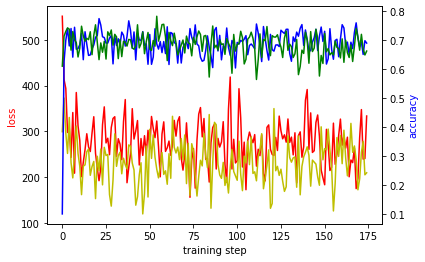

In [8]:
# visualization
final_loss = plot_val_loss[-1]
avg_loss = sum(plot_val_loss)/len(plot_val_loss)
final_acc = plot_val_accuracy[-1]
avg_acc = sum(plot_val_accuracy)/len(plot_val_accuracy)
print(avg_loss, final_loss, avg_acc, final_acc)

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()           # 做镜像处理
ax1.plot(plot_x, plot_train_loss, 'r-')
ax1.plot(plot_x, plot_val_loss, 'y-')
ax2.plot(plot_x, plot_train_accuracy, 'b-')
ax2.plot(plot_x, plot_val_accuracy, 'g-')
 
ax1.set_xlabel('training step')    #设置x轴标题
ax1.set_ylabel('loss',color = 'red')   #设置Y1轴标题
ax2.set_ylabel('accuracy',color = 'blue')   #设置Y2轴标题